<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
number of unique Item ID: 1559 , number of Ou

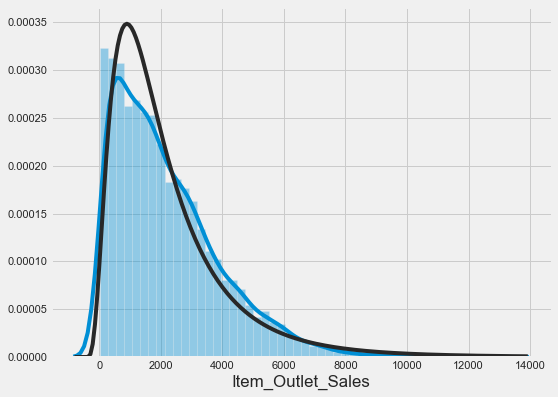

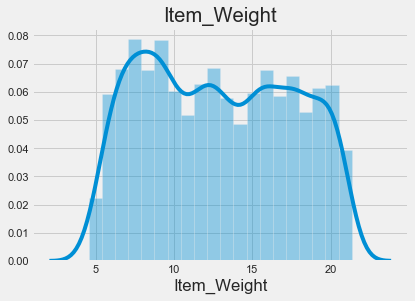

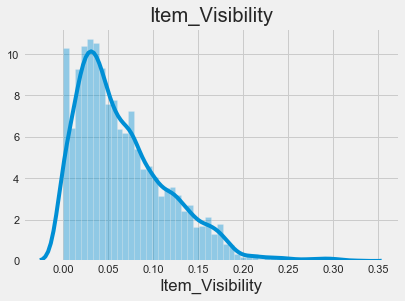

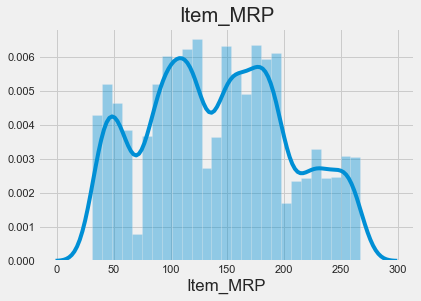

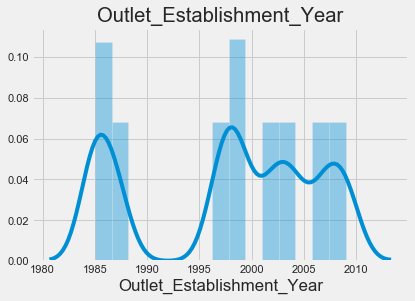

number of unique values for Item_Fat_Content : 5 
 ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
number of unique values for Item_Type : 16 
 ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
number of unique values for Outlet_Size : 4 
 ['Medium' nan 'High' 'Small']
number of unique values for Outlet_Location_Type : 3 
 ['Tier 1' 'Tier 3' 'Tier 2']
number of unique values for Outlet_Type : 4 
 ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


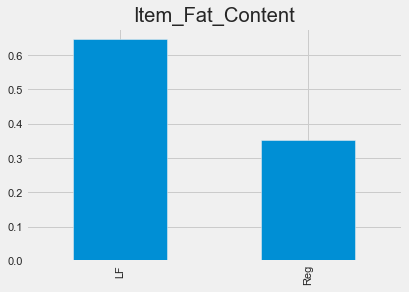

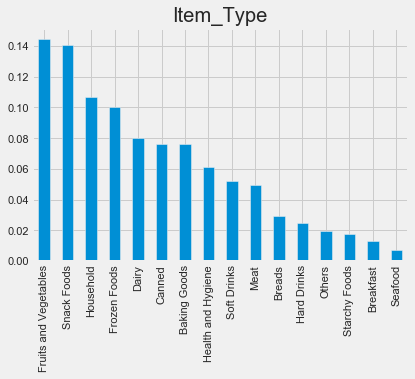

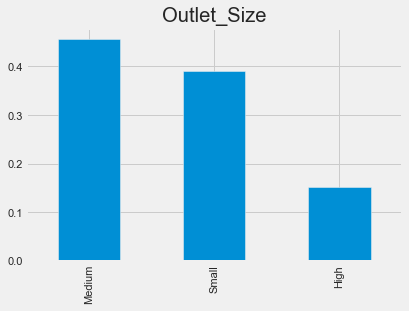

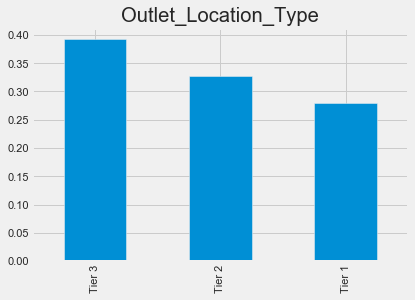

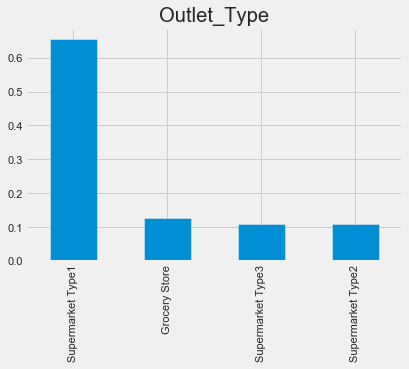

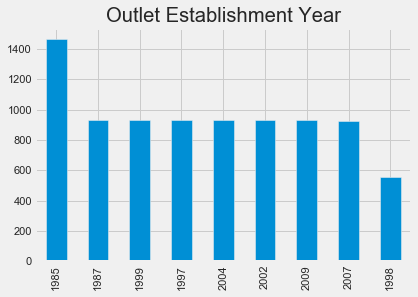

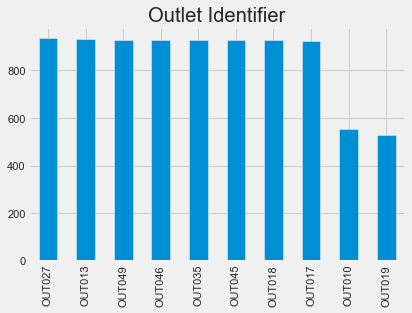

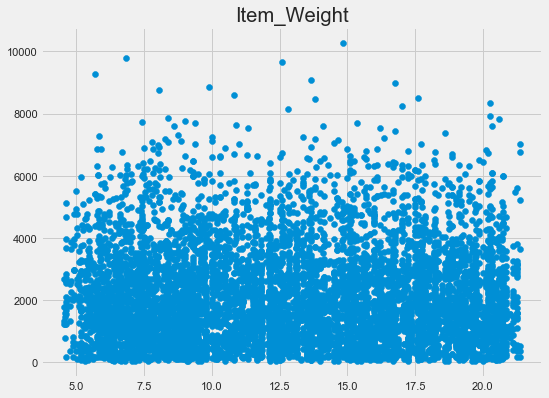

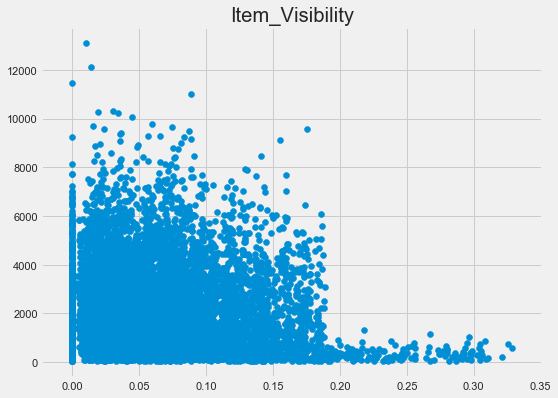

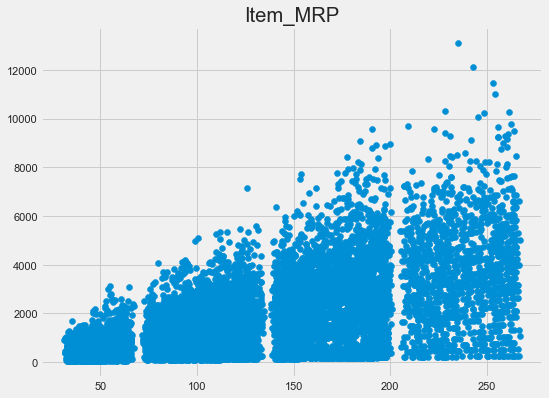

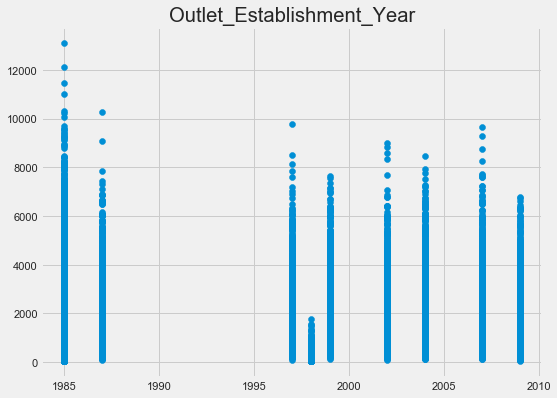

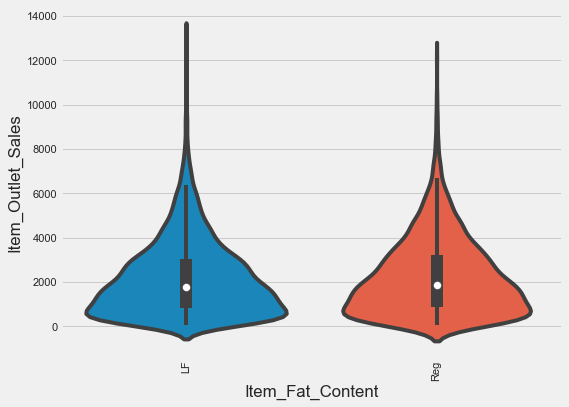

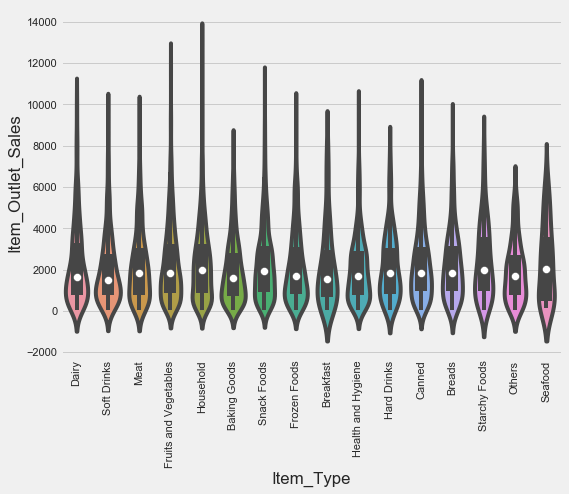

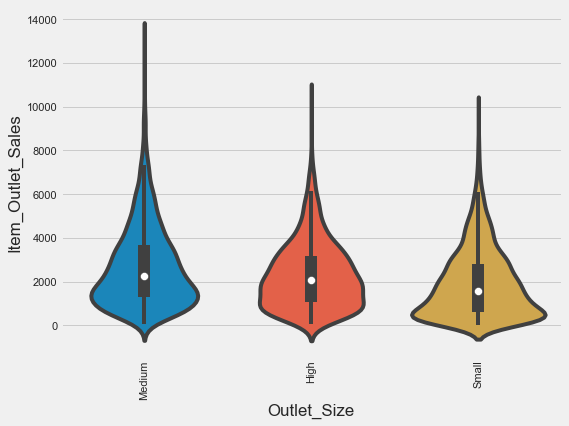

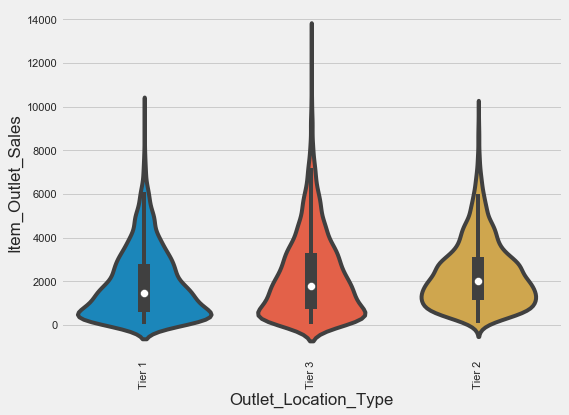

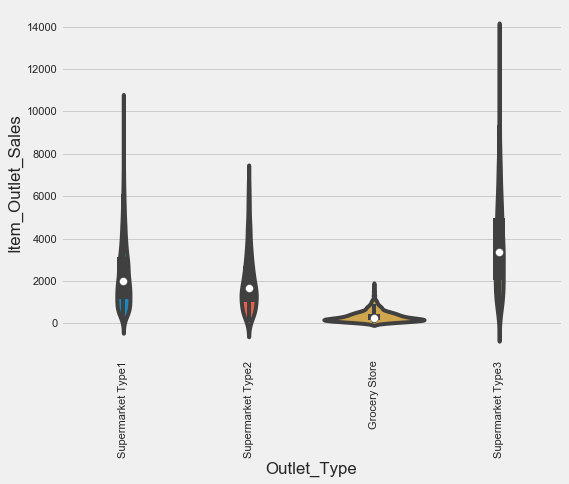

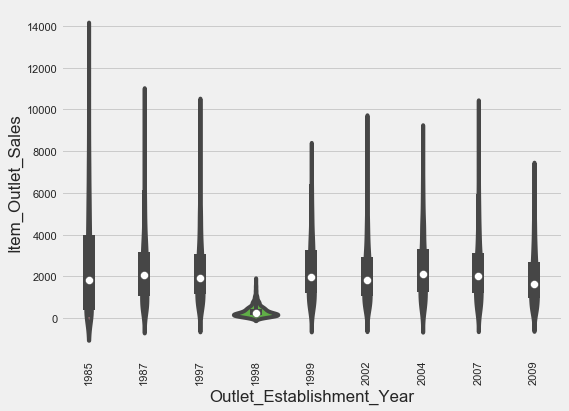

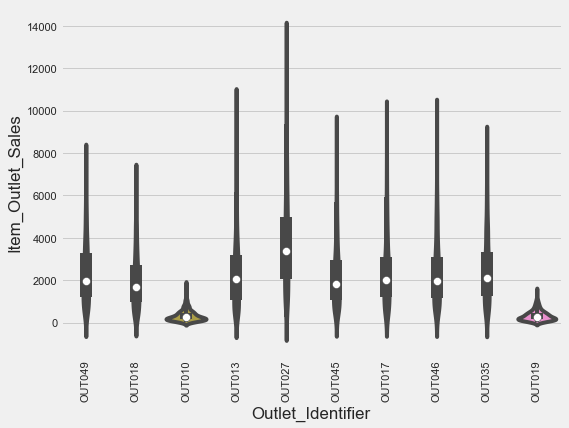

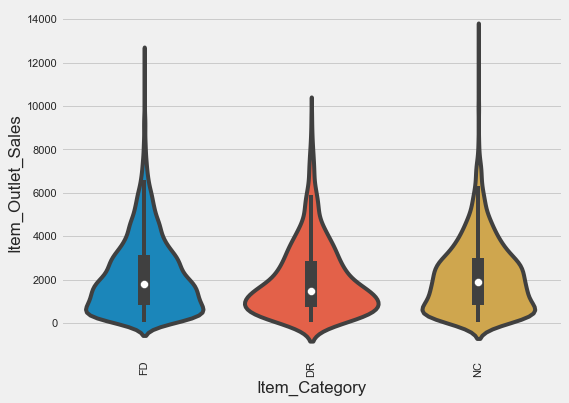

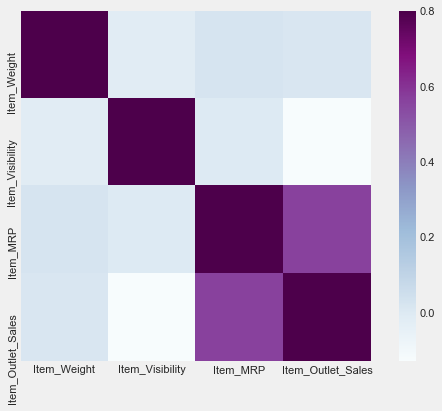

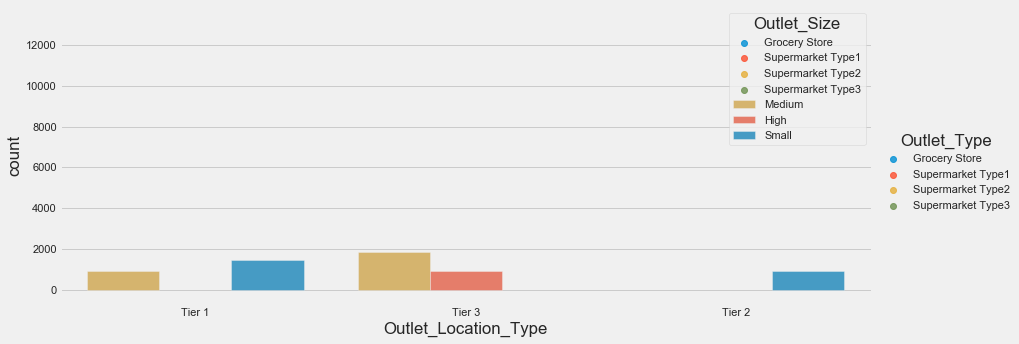

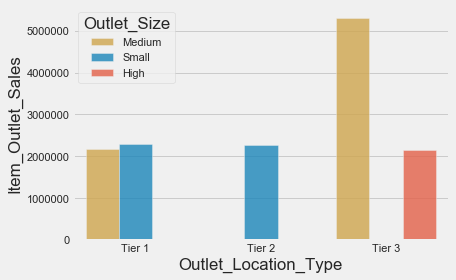

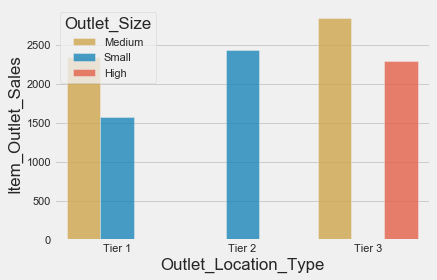

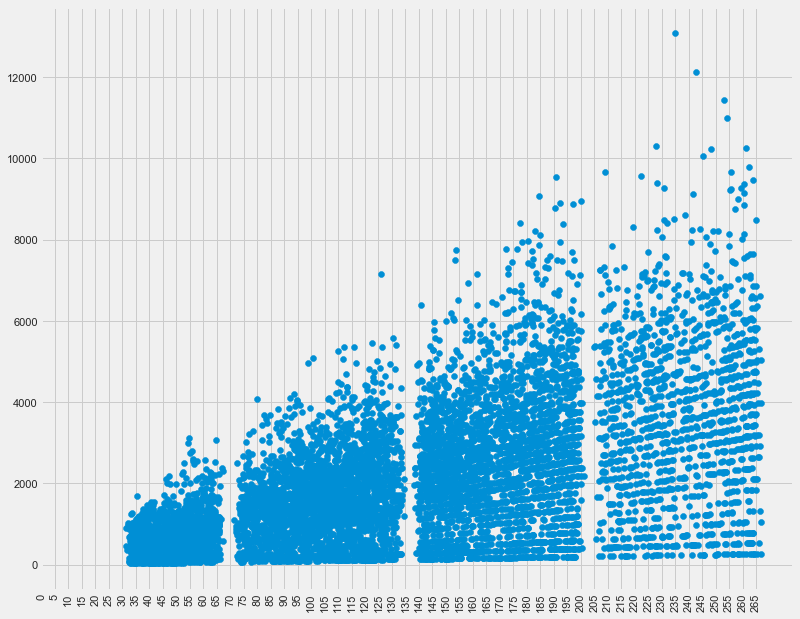

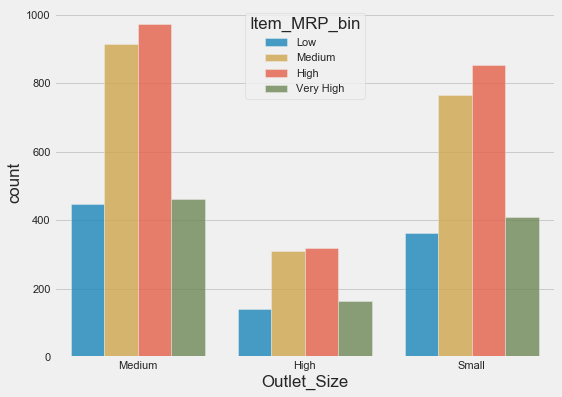

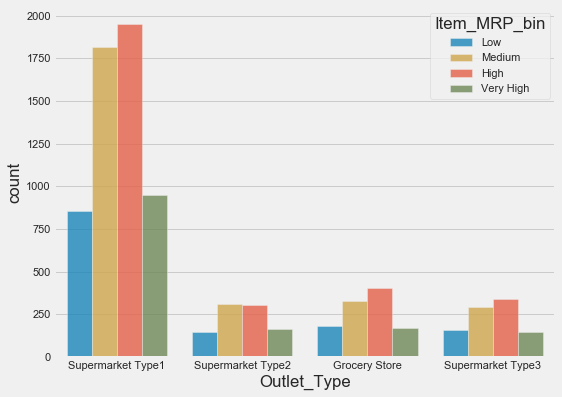

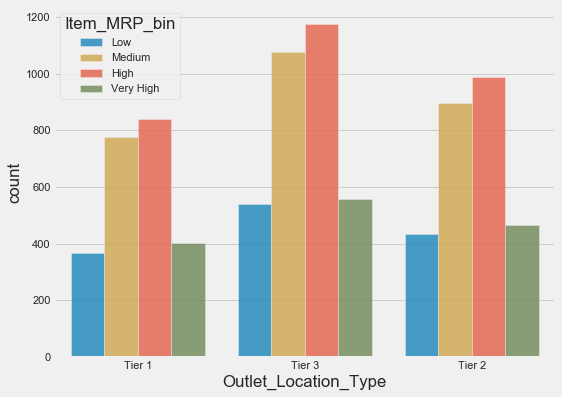

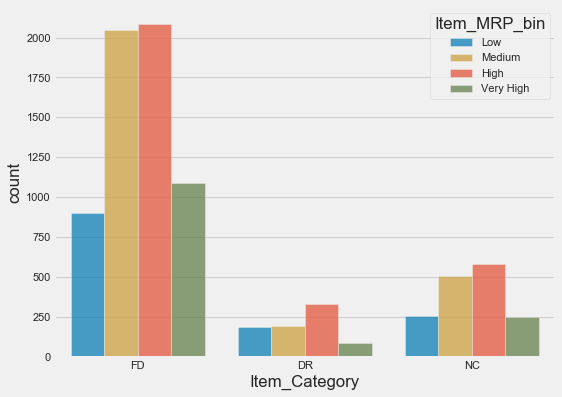

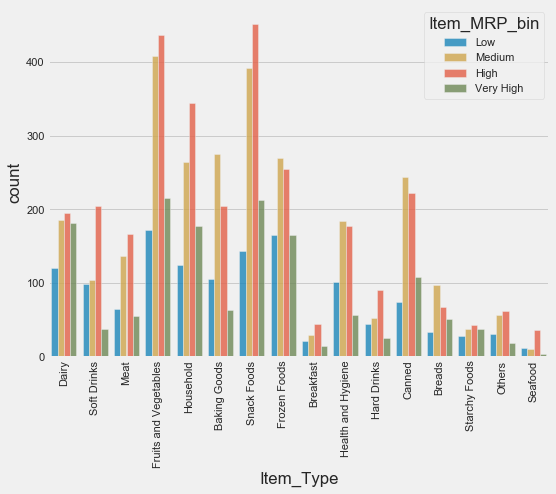

In [2]:
#import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
import scipy
from scipy import stats

train=pd.read_csv('Big_train.csv')
test=pd.read_csv('Big_test.csv')

train_original=train.copy()
test_original=test.copy()

## variable Identification

train.shape , test.shape

# the target variable data type 'Item_Outlet_Sales' is 'float64', hence we are facing a regression problem
# two columns comprises nan values
# feature are devided into two segments, Item features and outlet features
# MRP stands for :A maximum retail price (MRP), is a manufacturer calculated price that is the highest price that can be charged for a product sold in India and Bangladesh
train.info()

train.head()

## Univariate Analysis

# excluding Item_Identifier and Outlet_Identifier from features
# segmenting variable to numerical and categorical variables
# Outlet_Establishment_Year can be categorized as a Datetime variable later
org_features=[f for f in train.columns if f not in ['Item_Identifier', 'Outlet_Identifier']]
num=[f for f in org_features if train[f].dtype!='O']
cat=[f for f in org_features if train[f].dtype=='O']
target=train['Item_Outlet_Sales']

print('number of unique Item ID: {} , number of Outlets: {}'.format(len(train['Item_Identifier'].unique()), 
                                                                    len(train['Outlet_Identifier'].unique())))

#Analysing Target Variable
plt.figure(figsize=(8, 6))
sns.distplot(train['Item_Outlet_Sales'], fit=stats.johnsonsu)
plt.show()
#Target Variable is positively skewed, also the presence of outliers is obvious

####  it is a right skewd variable and would need some data transformation to treat its skewness.



def distplot(frame, features):
    plt.figsize=(10, 6)
    for feature in features:
        if feature != 'Item_Outlet_Sales':
            plt.title(feature)
            sns.distplot(frame[feature])
            plt.show()   

distplot(train, num)
# none of numerical values distibuted normaly, hence normalization is necessary.
# There seems to be no clear-cut pattern in Item_Weight.
# Outlet_Establishment_Year is a discrete variable. 
# We can clearly see 4 different distributions for Item_MRP, such an interesting insight!
# some values are zero for Item_Visibility feature, also it is right-skewed and should be transformed to curb its skewness.

#bins=[0,0.05,0.1,0.33]
#group=['Low', 'Average', 'High']
#train.Item_Visibility_bin= pd.cut(train.Item_Visibility, bins, labels=group)
#train.Item_Visibility_bin.value_counts().plot.bar(title='Item Visibility')
#plt.show()

for feature in cat:
    print('number of unique values for {} : {} \n {}'.format(feature,len(train[feature].unique()), train[feature].unique()))
# Item_Fat_Content has a number of duplicates with different names

# Since self values are not defined in mapping dictionary mapping.get(x, x) has been used
mapping={'Low Fat':'LF', 'low fat':'LF', 'Regular':'Reg', 'reg':'Reg'}
train['Item_Fat_Content']= train['Item_Fat_Content'].map(lambda x: mapping.get(x,x))
train.Item_Fat_Content.unique()

test['Item_Fat_Content']= test['Item_Fat_Content'].map(lambda x: mapping.get(x,x))
test['Item_Fat_Content'].unique()

def barplot(frame, features):
    for feature in features:
        frame[feature].value_counts(normalize=True).plot.bar(title=feature)
        plt.show()

barplot(train, cat)
# LF is roughly twice the value of Reg, however not all items include fat such as housholds, hygiene, etc.
# Fruits and vegetables followed by household and frozen foods incorporate a significant volume of items
# many of the outlets are medium-size, followed by small-size outlets
# most of the outlets are loccated in tier 3 cities, I assume tier 3 allocates to greater and more croweded cities
# most of the outlet types are supermarkets type 1

train.Outlet_Establishment_Year.value_counts().plot.bar(title='Outlet Establishment Year')
plt.show()
# many of the outlets has been established in 1985 and only a few ones in 1998, there is no difference between others
# there is not a specific pattern in establishment year to extract a meaninful insight in respect of time, hence it's better
# to convert it to categorical data
train['Outlet_Establishment_Year']=train['Outlet_Establishment_Year'].astype('object')
test['Outlet_Establishment_Year']=test['Outlet_Establishment_Year'].astype('object')

train.Outlet_Identifier.value_counts().plot.bar(title='Outlet Identifier')
plt.show()
# Outlet ID 10 and 19 repeated less than the others

train['Item_Identifier'].value_counts()
#Abbreviations in Item_Identifier might refer to specific type of products, lets investigate it later 

# Bivariate Analysis

## continuous-continuous: 
### analyzing continuous variables with respect to target variable

def scatter(frame, features):
    for feature in features:
        if feature !='Item_Outlet_Sales':
            plt.figure(figsize=(8,6))
            plt.title(feature)
            plt.scatter(frame[feature], target)
            plt.show()

scatter(train, num)
# there is no clear relationship between Item_weight, Item_Visibiity and target varibale, further investigation is required.
# zero value for Item_Visibility is questionable, more investigation is required
# there is an interestng pattern between Item_MRP and target variable, also it seems binning is necessary for this feature

#### Item_Outlet_Sales is spread well across the entire range of the Item_Weight without any obvious pattern.
#### In Item_Visibility vs Item_Outlet_Sales, there is a string of points at Item_Visibility = 0.0 which seems strange as item visibility cannot be completely zero. We will take note of this issue and deal with it in the later stages.
#### In the third plot of Item_MRP vs Item_Outlet_Sales, we can clearly see 4 segments of prices that can be used in feature engineering to create a new variable.


def violinplot(frame, features, y):
    for feature in features:
        plt.figure(figsize=(8, 6))
        sns.violinplot(frame[feature], y)
        plt.xticks(rotation=90)
        plt.show()

lst_1=cat+['Outlet_Establishment_Year', 'Outlet_Identifier']
violinplot(train, lst_1, target)

#### Tier 1 and Tier 3 locations of Outlet_Location_Type look similar.
#### In the Outlet_Type plot, Grocery Store has most of its data points around the lower sales values as compared to the other categories.
#### Distribution of Item_Outlet_Sales across the categories of Item_Type is not very distinct and same is the case with Item_Fat_Content.
#### The distribution for OUT010 and OUT019 categories of Outlet_Identifier are quite similar and very much different from the rest of the categories of Outlet_Identifier. they are both grocery stores, OUT019 is a small size outlet, however there's no information regarding the size of OUT010, given pattern similarity I think OUT010 is a small-size Outlet as well.

#it seems first two letters of Item_Identifier refer to type of Items, FD: Food, DR: Drink and NC: non-Consumbale
# I copy the dataframe so no changes will be applied to it during the EDA
data=train.copy()
data['Item_Category']=data['Item_Identifier'].apply(lambda row: row[:2])
data['Item_Category'].unique()

plt.figure(figsize=(8, 6))
sns.violinplot(data['Item_Category'], target)
plt.xticks(rotation=90)

matrix=train.corr()
plt.figure(figsize=(9,6))
sns.heatmap(matrix, vmax=0.8, square=True, cmap='BuPu')
plt.show()

### there is an obvious correlation between Item_MRP and Item_Outlet_Sales

# I want to look for relationships between variables more deeply,
def lmplot(frame, x, y, hue):
    data=frame.groupby([hue, x]).agg({y:np.median}).reset_index()
    sns.lmplot(x, y, data=data, fit_reg=False, hue=hue, aspect=2.5)
    plt.show

#lmplot(train, 'Item_Weight', 'Item_Outlet_Sales', 'Item_Type')
#lmplot(train, 'Item_Weight', 'Item_Outlet_Sales', 'Item_Fat_Content')
#lmplot(data, 'Item_Weight', 'Item_Outlet_Sales', 'Item_Category')
#lmplot(data, 'Item_MRP', 'Item_Outlet_Sales', 'Item_Category')
#lmplot(train,'Item_MRP', 'Item_Outlet_Sales','Item_Type')
#lmplot(train, 'Item_MRP','Item_Outlet_Sales', 'Outlet_Location_Type')
lmplot(train, 'Item_MRP','Item_Outlet_Sales', 'Outlet_Type')

train.groupby(['Outlet_Location_Type', 'Outlet_Size']).agg({'Item_Outlet_Sales':np.sum})

palette={'Small':'C0', 'Medium':'C2', 'High':'C1'}

sns.countplot('Outlet_Location_Type', hue='Outlet_Size', data=train, alpha=0.8, palette=palette )
plt.show()

Location_Size_Sales_Sum=train.groupby(['Outlet_Location_Type', 'Outlet_Size']).agg({'Item_Outlet_Sales':np.sum}).reset_index()
sns.barplot('Outlet_Location_Type', 'Item_Outlet_Sales', hue='Outlet_Size', 
            data= Location_Size_Sales_Sum, alpha=0.8, palette=palette)
plt.show()

Location_Size_Sales_Mean=train.groupby(['Outlet_Location_Type', 'Outlet_Size']).agg({'Item_Outlet_Sales':np.mean}).reset_index()
sns.barplot('Outlet_Location_Type', 'Item_Outlet_Sales', hue='Outlet_Size',
            data= Location_Size_Sales_Mean, alpha=0.8, palette=palette)
plt.show()

### Tier1 cities posess Medium & Small-size outlets, small-size outlets have sold more items, while Items in Medium-size have higher avg price
### Tier2 cities posses Only Small-size outlets
### Tier3 cities posses Medium and High-size outlets, medium-size outlets have sold more items, avg price is higher in those as well.

# lets find some insight regarding Item MRP which represents high correlation with target variable, but first we should bin the values and convert it to categorical
plt.figure(figsize=(12, 10))
plt.scatter(train['Item_MRP'], target)
plt.xticks(np.arange(0, np.max(train['Item_MRP']), 5), rotation=90)
plt.show()

bins=[0, 70, 135, 203, 267]
labels=['Low', 'Medium', 'High', 'Very High']

data['Item_MRP_bin']=pd.cut(data['Item_MRP'],  bins=bins, labels=labels)

palette={'Low':'C0', 'Medium':'C2', 'High':'C1', 'Very High':'C3'}


plt.figure(figsize=(8,6))
sns.countplot('Outlet_Size', hue='Item_MRP_bin', data=data, alpha=0.8, palette=palette)
plt.show()

plt.figure(figsize=(8,6))
sns.countplot('Outlet_Type', hue='Item_MRP_bin', data=data, alpha=0.8, palette=palette)
plt.show()

plt.figure(figsize=(8,6))
sns.countplot('Outlet_Location_Type', hue='Item_MRP_bin', data=data, alpha=0.8, palette=palette)
plt.show()

plt.figure(figsize=(8,6))
sns.countplot('Item_Category', hue='Item_MRP_bin', data=data, alpha=0.8, palette=palette)
plt.show()

plt.figure(figsize=(8,6))
sns.countplot('Item_Type', hue='Item_MRP_bin', data=data, alpha=0.8, palette=palette)
plt.xticks(rotation=90)
plt.show()



### It seems Size, Type, Location and even Item's Category does not affect MRP, which means in all these features, Items with High price followed by Medium price have been sold more than others.

### the pattern is more or less the same for Item_Type, however, for baking goods, frozen foods, hygiene, canned, and breads, medium price items have been sold slightly more than high price.
